In [1]:
import os
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as t_data
from utils import WeatherDatasetSimple
from models import FeatherNET_base, FeatherNET_contextualized, gradient_loss, spectral_loss
from model_eval import eval_model_single_frame, eval_results, eval_model_multiframe

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
train_dataset = WeatherDatasetSimple('data/wind/LR_train', 'data/wind/HR_train',  max_dataset_size=8448)
valid_dataset = WeatherDatasetSimple('data/wind/LR_val', 'data/wind/HR_val', max_dataset_size=1024)
test_dataset = WeatherDatasetSimple('data/wind/LR_test', 'data/wind/HR_test', max_dataset_size=1024)

In [3]:
batch_size = 16
train_dataloader = t_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = t_data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = t_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
feather_contextualized_model = FeatherNET_contextualized(memory_length=4).to(device) ## Remember 4 - 1 = 3 previous states

In [5]:
learning_rate = 1e-4
num_epochs = 200
criterion = gradient_loss ## Insert loss function here
optimizer = torch.optim.Adam(feather_contextualized_model.parameters(), lr=learning_rate )
outputs_dir = 'Models/FeatherNET/complete_(phase4)' # Folder for temporal output

In [6]:
def train__multiframe_model(model, optimizer, num_epochs, criterion, loss_history, outputs_dir, memory_length=4):
    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_psnr = 0.0
    for epoch in range(0, num_epochs):
        model.train()

        with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
            t.set_description('epoch: {}/{}'.format(epoch, num_epochs - 1))
            cur_loss = 0.0
            for lr, hr in train_dataloader:
                optimizer.zero_grad()
                lr = lr.to(device)
                hr = hr.to(device)

                hr_pred = model(lr)
                loss = 0.0
             #   for time_stamp in range(memory_length):
                time_stamp = memory_length - 1
                loss = criterion(hr_pred[time_stamp], hr[time_stamp : len(hr) - memory_length + 1 + time_stamp ]) 
                cur_loss += loss.item()  / (len(train_dataset) // batch_size)

                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1000.0)
                optimizer.step()

                t.set_postfix(loss='{:.6f}'.format(cur_loss))
                t.update(len(lr))

            torch.save(model.state_dict(), os.path.join(outputs_dir, 'FeatherNET_base_epoch_{}.pth'.format(epoch)))
            model.eval()
            epoch_result = eval_model_multiframe(model, valid_dataloader,  device=device)
            t.set_postfix({'train loss ': '{:.8f}'.format(cur_loss), 'evalPSNR' : epoch_result['psnr'], 'MAE' : epoch_result['mae']*255.0, 'MSE' : epoch_result['mse']*255.0*255.0, } )
            loss_history.append(epoch_result['psnr'])

            if epoch_result['psnr'] > best_psnr:
                best_epoch = epoch
                best_psnr = epoch_result['psnr']
                best_weights = copy.deepcopy(model.state_dict())

    print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
    torch.save(best_weights, os.path.join(outputs_dir, 'FeatherNET_base_best.pth'))

In [7]:
loss_history = []
train__multiframe_model(feather_contextualized_model, optimizer, 60, gradient_loss, loss_history, outputs_dir)

epoch: 0/59:   0%|                                                    | 16/8448 [00:03<26:59,  5.21it/s, loss=0.006222]


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 4.00 GiB total capacity; 1.69 GiB already allocated; 0 bytes free; 1.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
def train_model(model, optimizer, num_epochs, criterion, loss_history, outputs_dir):
    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_psnr = 0.0
    for epoch in range(0, num_epochs):
        model.train()

        with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
            t.set_description('epoch: {}/{}'.format(epoch, num_epochs - 1))
            cur_loss = 0.0
            for lr, hr in train_dataloader:
                optimizer.zero_grad()
                lr = lr.to(device)# /255.0
                hr = hr.to(device)# /255.0

                hr_pred = model(lr)
                if isinstance(hr_pred, list):
                    loss = 0.0
                    for otp in hr_pred:
                        loss += criterion(otp, hr)# * 255.0
                else:
                    loss = criterion(hr_pred, hr)#* 255.0
                cur_loss += loss.item()  / (len(train_dataset) // batch_size)

                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1000.0)
                optimizer.step()

                t.set_postfix(loss='{:.6f}'.format(cur_loss))
                t.update(len(lr))

            torch.save(model.state_dict(), os.path.join(outputs_dir, 'FeatherNET_base_epoch_{}.pth'.format(epoch)))
            model.eval()
            epoch_result = eval_model_single_frame(model, valid_dataloader,  device=device)
            t.set_postfix({'train loss ': '{:.8f}'.format(cur_loss), 'evalPSNR' : epoch_result['psnr'], 'MAE' : epoch_result['mae']*255.0, 'MSE' : epoch_result['mse']*255.0*255.0, } )
            loss_history.append(epoch_result['psnr'])

            if epoch_result['psnr'] > best_psnr:
                best_epoch = epoch
                best_psnr = epoch_result['psnr']
                best_weights = copy.deepcopy(model.state_dict())

    print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
    torch.save(best_weights, os.path.join(outputs_dir, 'FeatherNET_base_best.pth'))

In [11]:
loss_history = []
train_model(feather_contextualized_model, optimizer, 50, gradient_loss, loss_history, outputs_dir)

epoch: 49/49: 100%|█████| 8448/8448 [00:35<00:00, 236.42it/s, train loss =0.08147801, evalPSNR=25.8, MAE=10.8, MSE=244]

best epoch: 41, psnr: 25.86


In [14]:
print('both')

model = FeatherNET_contextualized(num_channels=1).to(device)
model.load_state_dict(torch.load('Models/FeatherNET/both_(phase3)/FeatherNET_base_best.pth'))
eval_model_single_frame(model, test_dataloader, device=device, verbose=True)

both
Evaluation completed. Metrics: 
mse :  0.003775269291594441  +-  0.0051201621453953105
mae :  0.04296039775181271  +-  0.023917733592893946
psnr :  25.789027479477227  +-  3.5114299185537385


C:\Users\9D20~1\AppData\Local\Temp/ipykernel_12580/3873723301.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  aa = torch.tensor([test_dataset[1][0]])


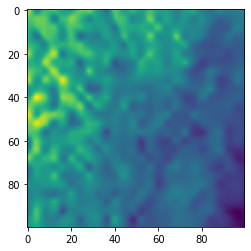

In [15]:
from PIL import Image
import matplotlib.pyplot as plt 

aa = torch.tensor([test_dataset[1][0]])
img_outp = model(aa.to(device))[0][0][0].cpu().detach().numpy()
plt.imsave('outputs/both_loss.png', img_outp, format='png')
plt.imshow(img_outp)

In [ ]:
eval_model_single_frame(model, test_dataloader, device=device, verbose=True)

In [18]:
eval_model_single_frame(model, test_dataloader, device=device, verbose=True)

Evaluation completed. Metrics: 
mse :  0.003762063916610714  +-  0.005098562865507072
mae :  0.04281270373667212  +-  0.023951298806748237
psnr :  25.81999930087477  +-  3.547563423985287


In [19]:
np.save('Models/FeatherNET_final_evalPSNR.npy', np.array(loss_history))

In [37]:
feather_contextualized_model = FeatherNET_base().to(device)
learning_rate = 1e-3
num_epochs = 200
criterion = gradient_loss#spectral_loss
optimizer = torch.optim.Adam(feather_contextualized_model.parameters(), lr=learning_rate)

outputs_dir = 'Models/FeatherNET/specloss_(phase1)'
loss_history_2 = []
train_model(feather_contextualized_model, optimizer, 50, criterion, loss_history_2, outputs_dir)

epoch: 49/49: 100%|█████| 8448/8448 [00:24<00:00, 350.23it/s, train loss =0.07766434, evalPSNR=25.8, MAE=10.8, MSE=244]

best epoch: 2, psnr: 25.93


In [39]:
#np.save('Models/FeatherNET+specloss_final_evalPSNR.npy', np.array(loss_history_2))

In [ ]:
#feather_contextualized_model = FeatherNET_base().to(device)
for i in range(100):
    x = torch.tensor([train_dataset[i][0]]).to(device)
    y_pred=feather_contextualized_model(x)
    y_true = torch.tensor([train_dataset[i][1]]).to(device)
    
    l1 = nn.L1Loss()
    mse = nn.MSELoss()
    
    a1 = torch.fft.rfft2(y_pred, norm='forward').abs() ** 2
    a2 = torch.fft.rfft2(y_true, norm='forward').abs() ** 2
    print(1e-2*mse(a1, a2).item(), '<<>>>', l1(y_pred, y_true).item())

In [120]:
#np.save('Models/FeatherNET+grad_loss_evalPSNR.npy', np.array(loss_history))

In [18]:
result = eval_model_single_frame(feather_contextualized_model, test_dataloader, device=device)
print("FeatherNet_contextualized model best results: ")
print("MSE:  ", result['mse'])
print("MAE:  ", result['mae'])
print("PSNR: ", result['psnr'])

FeatherNet_contextualized model best results: 
MSE:   0.002556319240525795
MAE:   0.03085265790377889
PSNR:  26.91523647494614


In [177]:
result = eval_model_single_frame(feather_base_model, test_dataloader, device=device)
print("FeatherNet_specloss model best results: ")
print("MSE:  ", result['mse'])
print("MAE:  ", result['mae'])
print("PSNR: ", result['psnr'])

FeatherNet_specloss model best results: 
MSE:   0.00021845255657439278
MAE:   0.010027477570122323
PSNR:  29.664134038637762


In [12]:
result = eval_model_single_frame(feather_base_model, test_dataloader, device=device)
print("FeatherNet_base model best results: ")
print("MSE:  ", result['mse'])
print("MAE:  ", result['mae'])
print("PSNR: ", result['psnr'])

FeatherNet_base model best results: 
MSE:   0.00021225229570580716
MAE:   0.009835903431765495
PSNR:  29.83789853060549
